# Setup

In [37]:
import numpy as np
import matplotlib.pyplot as plt
# from pycqed.analysis_v2.base_analysis import BaseDataAnalysis
from pycqed.analysis import analysis_toolbox as a_tools
from pycqed.analysis_v2 import readout_analysis as ra
import os
import matplotlib
import matplotlib.colors as mc
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.mixture import GaussianMixture as GM
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from importlib import reload
import h5py
from pycqed.analysis import measurement_analysis as ma
import datetime


# matplotlib.rcParams.update({'font.size': 20})
a_tools.datadir = "Q:\\USERS\\nathan\\data"
figsave_base = "C:\\Users\\nathan\\projects\\master_thesis\\appendices\\qutrit_readout\\figs"

## Plotstyle

In [2]:
fig_size_dim    = 8
golden_ratio    = (1+np.sqrt(5))/2
fig_size        = (fig_size_dim, fig_size_dim/golden_ratio)
colors = ["#3673AF", "#39B265", "#734687", "#873D48", "#2D3142"]
def plot_style():
    font_size       = 16
    marker_size     = 6
    line_width      = 2.5
    axes_line_width = 1
    tick_length     = 5
    tick_width      = 1
    tick_color      = 'k'
    ticks_direction = 'in'
    axes_labelcolor = 'k'
    dpi             =  700

    params = {'figure.figsize': fig_size,
              'figure.dpi': dpi,
              'savefig.dpi': dpi,
              'font.size': font_size,
              'font.family': "DIN Pro",#"cmss10", #"DINPro", # to manage to use dinpro, put ttf files in site-packages/matplotlib/mpl-data/fonts
              'mathtext.default': 'it',
              'mathtext.fontset': "cm",
              'mathtext.it': 'cm',
              'figure.titlesize': font_size,
              'legend.fontsize': font_size,
              'axes.labelsize': font_size,
              'axes.labelcolor': axes_labelcolor,
              'axes.titlesize': font_size,
              'axes.linewidth': axes_line_width,
              'lines.markersize': marker_size,
              'lines.linewidth': line_width,
              'xtick.direction': ticks_direction,
              'ytick.direction': ticks_direction,
              'xtick.labelsize': font_size,
              'ytick.labelsize': font_size,
              'xtick.color': tick_color,
              'ytick.color': tick_color,
              'xtick.major.size': tick_length,
              'ytick.major.size': tick_length,
              'xtick.major.width': tick_width,
              'ytick.major.width': tick_width,
              'xtick.minor.size': tick_length - 2,
              'ytick.minor.size': tick_length - 2,
              'xtick.major.width': tick_width,
              'ytick.major.width': tick_width,
              'xtick.top': True,
              'xtick.bottom': True,
              'ytick.left': True,
              'ytick.right': True,
              'axes.formatter.useoffset': False,

              # LEGEND
            'legend.loc'           : 'best',
            'legend.frameon'       : False,     ## if True, draw the legend on a background patch
    #         'legend.framealpha'    : 0.8,      ## legend patch transparency
    #         'legend.facecolor'     : 'inherit',  ## inherit from axes.facecolor; or color spec
    #         'legend.edgecolor'     : 0.8,      ## background patch boundary color
    #         'legend.fancybox'      : True,     ## if True, use a rounded box for the
                                             ## legend background, else a rectangle
                }

    plt.rcParams.update(params)
plot_style()

## Functions 

In [3]:
datadir = "Q:\\USERS\\nathan\\data"


def plot_confusion_matrix(cm, target_names, title='Confusion matrix',
                          cmap=None, normalize=True):
    fidelity_avg = np.trace(cm) / float(np.sum(cm))

    if cmap is None:
        cmap = plt.get_cmap('coolwarm')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, norm=mc.LogNorm())
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Prepared State')
    plt.xlabel('Predicted State\n$\mathcal{{F}}_{{avg}}$={:0.2f} %'.format(fidelity_avg*100))
    plt.show()

# create own colormap
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


cmap = plt.get_cmap('tab10')
tab3 = truncate_colormap(cmap, 0, 0.299)
# arr = np.linspace(0, 50, 100).reshape((10, 10))
# fig, ax = plt.subplots(ncols=2)
# ax[0].imshow(arr, interpolation='nearest', cmap=cmap)
# ax[1].imshow(arr, interpolation='nearest', cmap=tab3)

###### plot boundaries ###
def make_meshgrid(x, y, h=.005, margin=0.5):
    x_min, x_max = x.min() - margin, x.max() + margin
    y_min, y_max = y.min() - margin, y.max() + margin
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def plot_data_and_boundaries(X, y_true, clf, ax=None, cmap=tab3):
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(10, 10))
    title = 'Decision surface of {}'.format(str(clf).split('(')[0])

    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    ax.scatter(X0, X1, c=y_true, cmap=cmap, marker='.', alpha=0.7)
    plot_contours(ax, clf, xx, yy, cmap=cmap, alpha=0.3)
    
    ax.set_ylabel('Integration Unit 2')
    ax.set_xlabel('Integration Unit 1')
    #ax.set_xlim([-0.5,1.3])
    #ax.set_ylim([-1.1, 0.9])
    ax.set_title(title)
    
import pycqed.analysis.fit_toolbox.geometry as geo
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
def restricted_angle(angle):
        entire_div = angle // (np.sign(angle)*np.pi)
        return angle - np.sign(angle) * entire_div * 2 * np.pi
def f(gamma, val1=0, val2=1/(2*np.pi)):
    gamma = restricted_angle(gamma)
    return val1 if gamma > -np.pi/2 and gamma < np.pi/2 else val2
def evaluate_fidelity(spectra, sigma):
    def g(x, d, sigma=0.1):
        x = restricted_angle(x)
        return np.exp(-d ** 2 / np.cos(x) ** 2 / (2 * sigma ** 2))

    def integral(angle, dist, sigma):
        const = 1 / (2 * np.pi)
        p1 = const * integrate.quad(lambda x: f(x, g(x, dist, sigma=sigma), 0), angle - np.pi, angle)[0]
        return  -p1 + integrate.quad(lambda x: f(x), angle - np.pi, angle)[0] +  integrate.quad(lambda x: f(x, 1/(2*np.pi), 0), angle - np.pi, angle)[0]

    assert len(spectra) == 3, "3 spectra required for qutrit F_RO " \
                              "analysis. Found {}".format((len(spectra)))
    i1s, i2s, i3s = [], [], []
    # in most cases, states will be ['g', 'e', 'f'] but to ensure not to
    # be dependent on labels we take indices of keys
    states = list(spectra.keys())
    for i in range(len(spectra[states[0]])):
        pt1 = (spectra[states[0]][i].real, spectra[states[0]][i].imag)
        pt2 = (spectra[states[1]][i].real, spectra[states[1]][i].imag)
        pt3 = (spectra[states[2]][i].real, spectra[states[2]][i].imag)
        d1 = geo.distance(pt1, pt2) / 2
        d2 = geo.distance(pt2, pt3) / 2
        d3 = geo.distance(pt1, pt3) / 2
        # translate to point1
        pt2 = tuple(np.asarray(pt2) - np.asarray(pt1))
        pt3 = tuple(np.asarray(pt3) - np.asarray(pt1))
        pt1 = (0., 0.)
        c, R = geo.circumcenter(pt2, pt3, pt1, show=False)
        gamma1 = np.arccos(d1 / R)
        gamma2 = np.arccos(d2 / R)
        gamma3 = np.arccos(d3 / R)
        i1 = integral(gamma1, d1, sigma)
        i2 = integral(gamma2, d2, sigma)
        i3 = integral(gamma3, d3, sigma)
        i1s.append(i1)
        i2s.append(i2)
        i3s.append(i3)

    i1s, i2s, i3s = np.array(i1s), np.array(i2s), np.array(i3s)
    total_area = 2 * i1s + 2 * i2s + 2 * i3s
   # print(total_area)
    avg_fidelity = total_area / 3
    fid_state_0 = i1s + i3s
    not0 = 1 - fid_state_0
    fid_state_1 = i1s + i2s
    not1 = 1 - i1s + i2s
    fid_state_2 = i2s + i3s
    not2 = 1 - fid_state_2

    single_level_fid = {states[0]: fid_state_0,
                        states[1]: fid_state_1,
                        states[2]: fid_state_2}

    return avg_fidelity, single_level_fid
    
    
    
import h5py

def get_hdf_params_values(timestamp, params_paths):
    folder = a_tools.get_folder(timestamp)
    h5mode =  'r+'
    h5filepath = a_tools.measurement_filename(folder)
    hdf5file = h5py.File(h5filepath, h5mode)
    if np.ndim(params_paths) == 0:
        params_paths = [params_paths]
    params_values = {p: [] for p in params_paths}
    
    for p in params_paths:
        params_values[p] = []
        path_elements = p.split("/")
        try:
            # p refers to a dataset
            params_values[p].append(hdf5file[p]) 
        except KeyError as e:
            try:
                #p refers to an attribute
                params_values[p].append(eval(hdf5file["/".join(path_elements[:-1])].attrs[path_elements[-1]]))
            except Exception as e2:
                raise e2
    return params_values

def std_error(p, nshots=10000):
    return np.sqrt(np.abs(p)*(1-np.abs(p))/nshots)


# Load and plot Data

## spectroscopy

In [4]:
# spec traces
timestamps= ["20191210_181819", "20191210_182047", "20191210_182317"]
levels = 'gef'
qbn = 'qb1'
rescale = 1 # because for current measurement still devide by nr average in det func. Should be fixed in future
m_a = {l: ma.MeasurementAnalysis(timestamp=t) for l,t in zip(levels, timestamps)}
trace = {l: rescale * m_a[l].measured_values[0] *
            np.exp(1j * np.pi * m_a[l].measured_values[1] / 180.)
         for l in levels}
freqs_spec = m_a['g'].sweep_points
a = ma.MeasurementAnalysis(timestamp=timestamps[0], auto=False)
ro_freq = a.data_file['Instrument settings'][qbn].attrs['ro_freq']

c:\users\nathan\code\quantumsoftware\pycqed_py3\pycqed\analysis\measurement_analysis.py:277: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  values = self.g[key].value


Q:\USERS\nathan\data\20191210\181819_g-spec_qb1\g-spec_qb1_measured_values_vs_Readout frequency.png ::loc


c:\users\nathan\code\quantumsoftware\pycqed_py3\pycqed\analysis\measurement_analysis.py:277: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  values = self.g[key].value


Q:\USERS\nathan\data\20191210\182047_e-spec_qb1\e-spec_qb1_measured_values_vs_Readout frequency.png ::loc


c:\users\nathan\code\quantumsoftware\pycqed_py3\pycqed\analysis\measurement_analysis.py:277: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  values = self.g[key].value


Q:\USERS\nathan\data\20191210\182317_f-spec_qb1\f-spec_qb1_measured_values_vs_Readout frequency.png ::loc


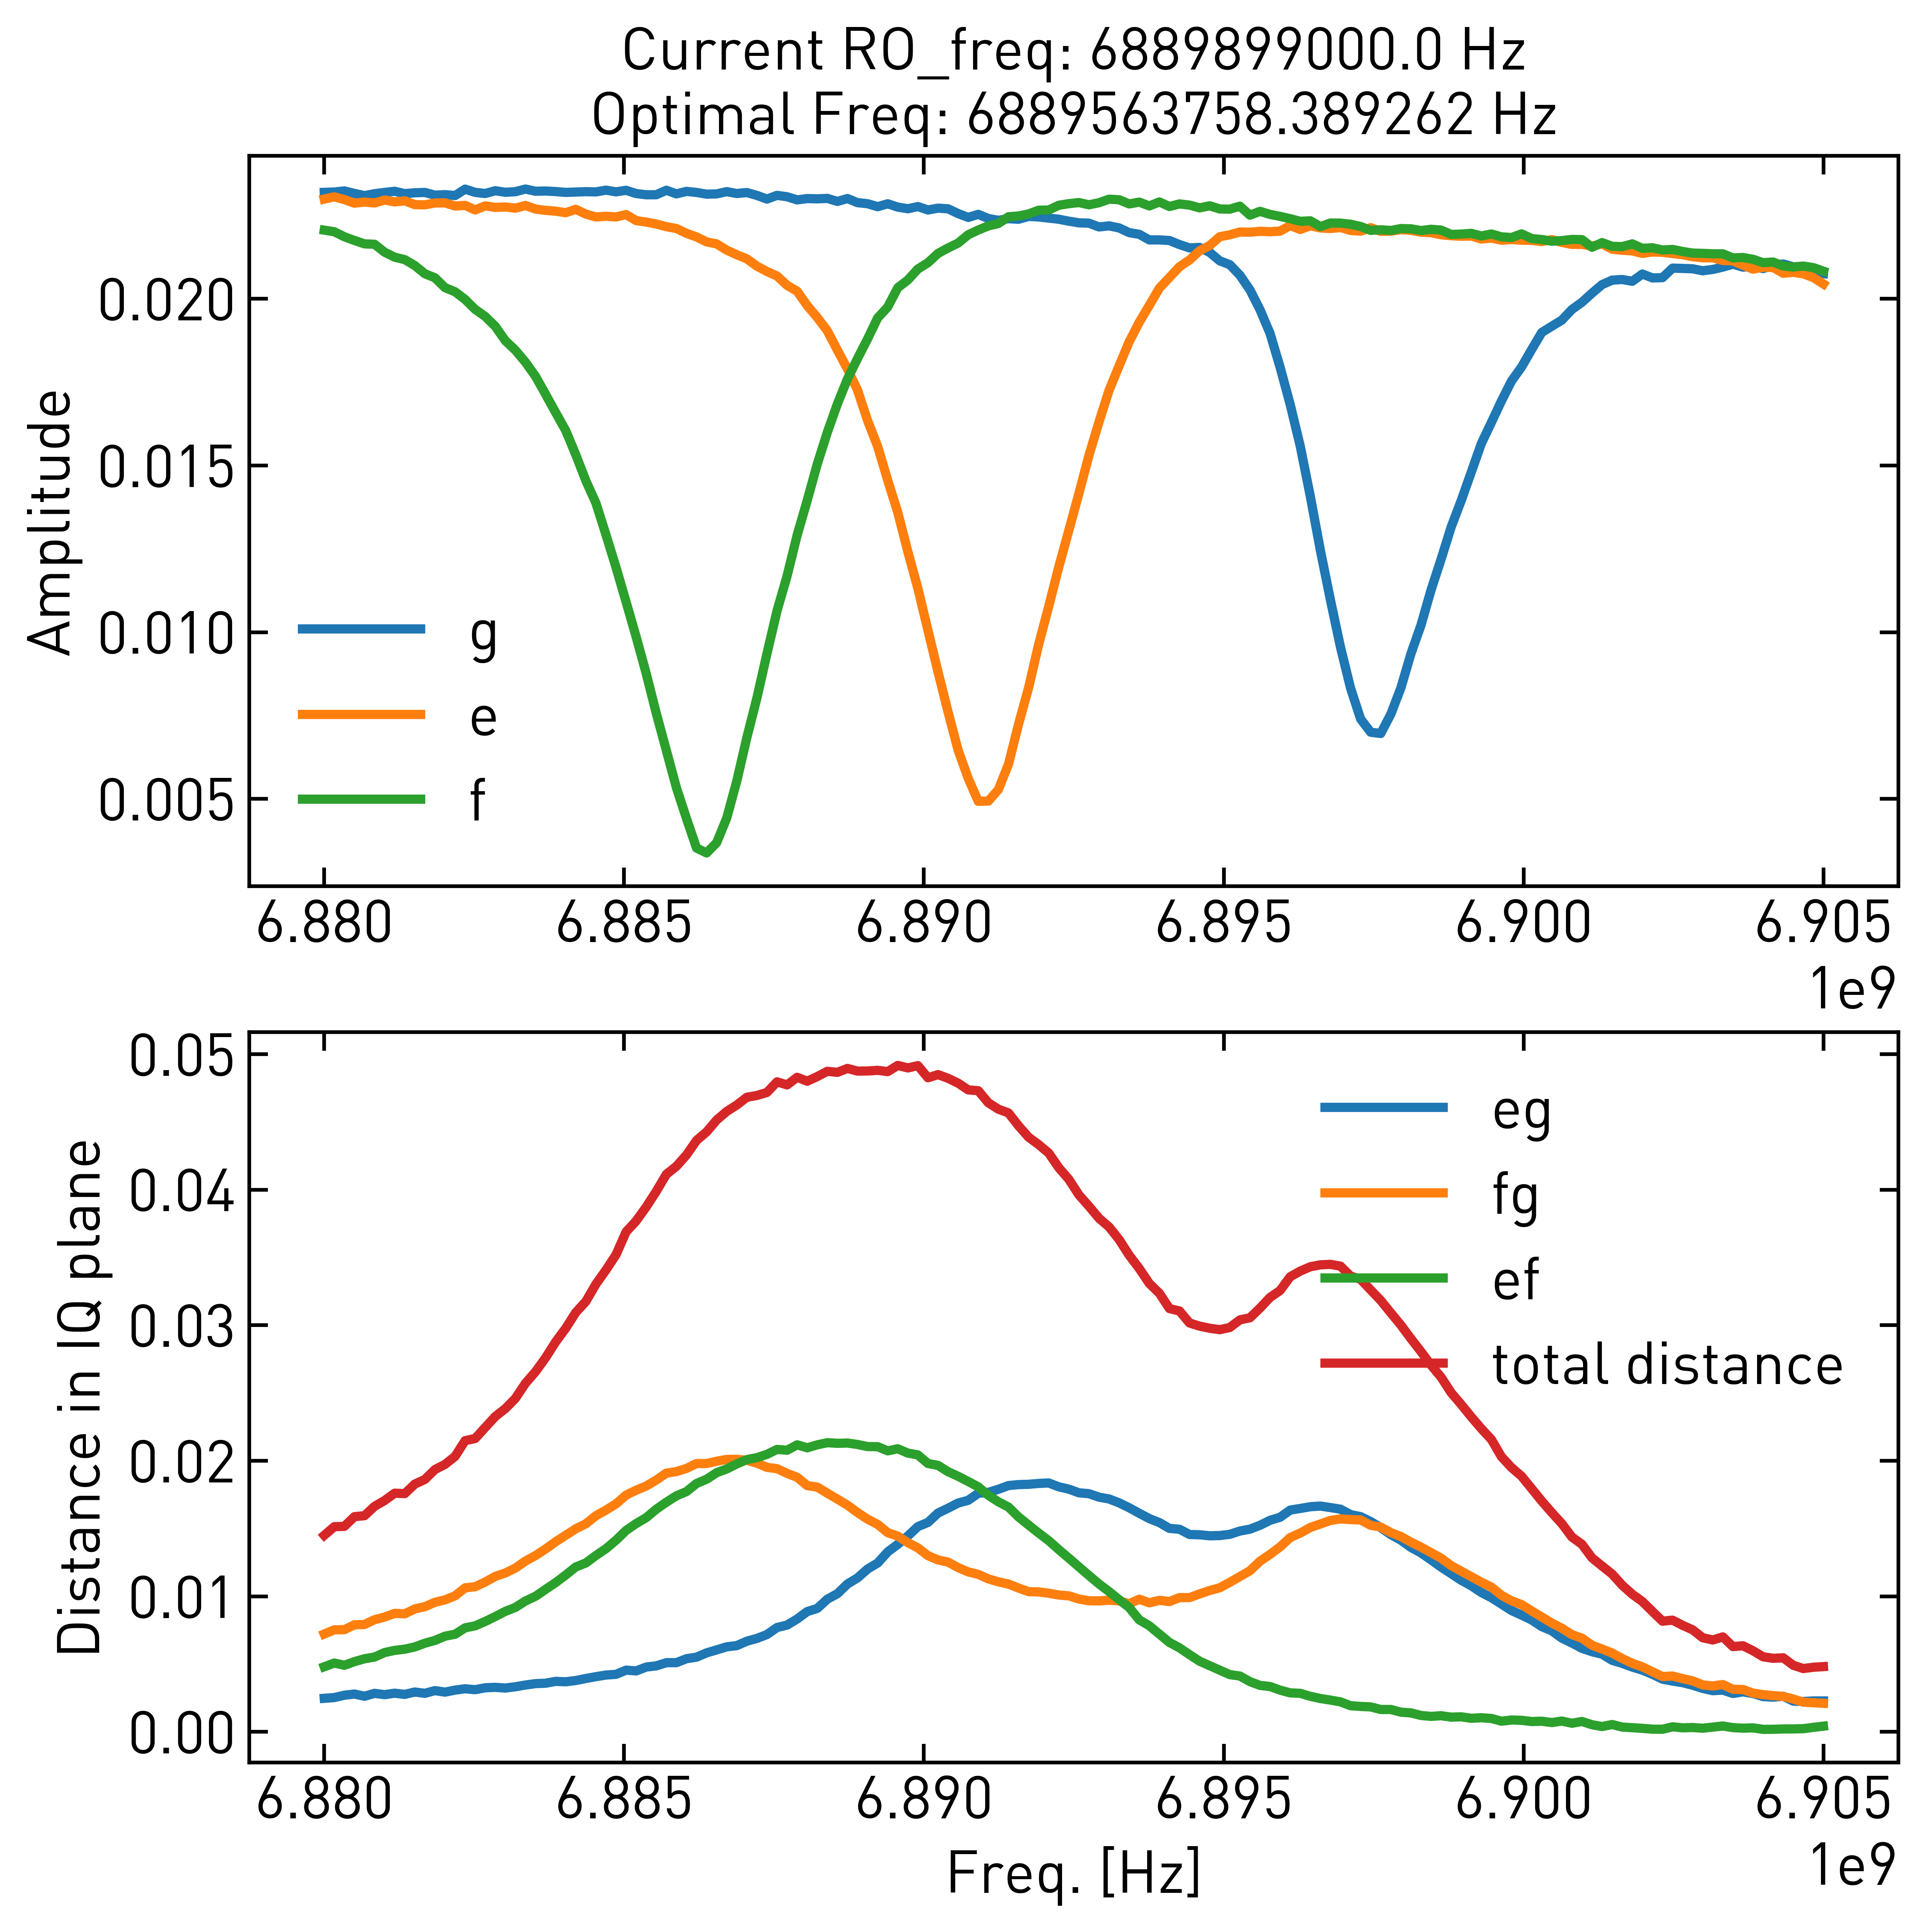

NameError: name 'freqs' is not defined

In [5]:
# plot
total_dist = np.abs(trace['e'] - trace['g']) + \
             np.abs(trace['f'] - trace['g']) + \
             np.abs(trace['f'] - trace['e'])
fmax = freqs_spec[np.argmax(total_dist)]
# FIXME: just as debug plotting for now
fig, ax = plt.subplots(2, figsize=(8,8))
ax[0].plot(freqs_spec, np.abs(trace['g']), label='g')
ax[0].plot(freqs_spec, np.abs(trace['e']), label='e')
ax[0].plot(freqs_spec, np.abs(trace['f']), label='f')
ax[0].set_ylabel('Amplitude')
ax[0].legend()
ax[1].plot(freqs_spec, np.abs(trace['e'] - trace['g']), label='eg')
ax[1].plot(freqs_spec, np.abs(trace['f'] - trace['g']), label='fg')
ax[1].plot(freqs_spec, np.abs(trace['e'] - trace['f']), label='ef')
ax[1].plot(freqs_spec, total_dist, label='total distance')
ax[1].set_xlabel("Freq. [Hz]")
ax[1].set_ylabel('Distance in IQ plane')
ax[0].set_title("Current RO_freq: {} Hz\nOptimal Freq: {} Hz".format(ro_freq, fmax))
plt.legend()

#m_a['g'].save_fig(fig, 'IQplane_distance')
plt.show()
fmax = freqs[np.argmax(np.abs(trace['e'] - trace['g']))]

## SSB SSRO

In [6]:
tstart = "20191210_183019"
tend = "20191210_185306"
levels = 'gef'
int_length = 400e-9
rescale = 1/ (1.8e9*int_length)
plot= True
options = dict(pre_selection=True, classif_method='gmm', show=plot, classif_kw=dict(covariance_type='tied'), 
               hist_scale="log")

tps = a_tools.get_timestamps_in_range(tstart, tend)

In [11]:

all_analyses = []
ssb_ro_freqs = []
ssb_avg_fid = []
state_assignment_prob_mtx = []
ssb_avg_fid_masked = []
state_assignment_prob_mtx_masked = []
for ts in zip(*[iter(tps)]*3):
    ro = list(get_hdf_params_values(ts[0], "Instrument settings/qb1/ro_freq").values())[0][0]
    ssb_ro_freqs.append(ro)
    agmm = ra.Singleshot_Readout_Analysis_Qutrit(auto=False,
                                                   t_start = list(ts),
                                                   levels=levels,
                                                   options_dict=options)
    agmm.extract_data()
    
    for i in range(len(levels)):
        [agmm.raw_data_dict[i]["measured_data"].update({k: v*rescale}) for k, v in agmm.raw_data_dict[i]["measured_data"].items() ]
    agmm.process_data()
    state_assignment_prob_mtx.append(agmm.proc_data_dict['analysis_params']['state_prob_mtx'])
    state_assignment_prob_mtx_masked.append(agmm.proc_data_dict['analysis_params']['state_prob_mtx_masked'])
    ssb_avg_fid.append(np.mean(agmm.proc_data_dict['analysis_params']['state_prob_mtx'][np.eye(3, dtype=bool)]))
    ssb_avg_fid_masked.append(np.mean(agmm.proc_data_dict['analysis_params']['state_prob_mtx_masked'][np.eye(3, dtype=bool)]))
#     agmm.prepare_plots()
#     agmm.plot(key_list='auto')
    plt.close('all')
    all_analyses.append(agmm)
ssb_avg_fid = np.array(ssb_avg_fid)
ssb_avg_fid_masked = np.array(ssb_avg_fid_masked)
state_assignment_prob_mtx_masked = np.array(state_assignment_prob_mtx_masked)
state_assignment_prob_mtx = np.array(state_assignment_prob_mtx)

# get ssb ro freqs
ssb_ro_freqs = []
for ts in zip(*[iter(tps)]*3):
    ro = list(get_hdf_params_values(ts[0], "Instrument settings/qb1/ro_freq").values())[0][0]
    ssb_ro_freqs.append(ro)
ssb_ro_freqs = np.array(ssb_ro_freqs)*1e-9

# get relevant parameters for model
means = [a.clf_.means_ for a in all_analyses]
means_cpx = [{s: [complex(*means_f[i])] for i, s in enumerate(levels)} for means_f in means]
try:
    stds =  [np.sqrt(np.mean(a.clf_.covariances_[np.eye(2, dtype=bool)])) for a in all_analyses]
except IndexError:
    # if full covariance matrix is used
    cov = [a.clf_.covariances_ for a in all_analyses]
    stds_g_only = [np.mean(c[0][np.eye(2, dtype=bool)]) for c in cov]
    stds =  [np.sqrt(np.mean([a.clf_.covariances_[i][np.eye(2, dtype=bool)] for i in range(3)])) for a in all_analyses]

In [12]:
# compute singular value decompostion for errorbars
sv = np.array([sorted(np.linalg.svd(m)[1])[0] for m in state_assignment_prob_mtx_masked])
n_shots = list(get_hdf_params_values(ts[0], "Instrument settings/qb1/acq_shots").values())[0][0]

errorbars = []
for p in [np.array(state_assignment_prob_mtx_masked)[:,i,i] for i in range(3)]:
    errorbars.append(np.sqrt(p*(1-p))/(np.sqrt(n_shots))*np.sqrt(1/sv**2))
errorbars_fid = np.sum(errorbars, axis=0)*100
errorbars_fid

array([0.97939813, 0.68139788, 0.65763132, 0.6071231 , 0.55739434,
       0.53962513, 0.49124741, 0.47163884, 0.4258214 , 0.41199771,
       0.41456879, 0.38965142, 0.38507369, 0.32503146, 0.39091682,
       0.35962937, 0.29651209, 0.30476331, 0.29119335, 0.30593731,
       0.32636679, 0.32703207, 0.34256186, 0.34577473, 0.35729781,
       0.36370974, 0.37623445, 0.37888415, 0.38974531, 0.39214092])

In [180]:
# optional : retrain on masked data to avoid skew due to thermal pop
means_retrained = []
for an in all_analyses:
    an.clf_.fit(an.proc_data_dict['data_masked']['X'], an.proc_data_dict['data_masked']['prep_states'])
    means_retrained.append(an.clf_.means_)
means_retrained_cpx = [{s: [complex(*means_f[i])] for i, s in enumerate(levels)} for means_f in means_retrained]
avg_fidelity_gmm_retrained = np.array([evaluate_fidelity(m, s)[0][0] for m, s in zip(means_retrained_cpx, stds)])


## prepare plot

In [13]:
colors = ['#3673AF','#FF6947', "#39B265"]

# Compute expected infidelity with model on spec and evaluated points
avg_fidelity_gmm_ssb = np.array([evaluate_fidelity(m, s)[0][0] for m, s in zip(means_cpx, stds)])
avg_fidelity_spec = np.array(evaluate_fidelity(trace, np.mean(stds[1:]))[0])

# show measured fidelities
plot_start = 1 
plot_end = None

## Plot

In [14]:
other_colors = [ "#734687", "#873D48", "#2D3142"]
c = '#734687' #'#7339ac'

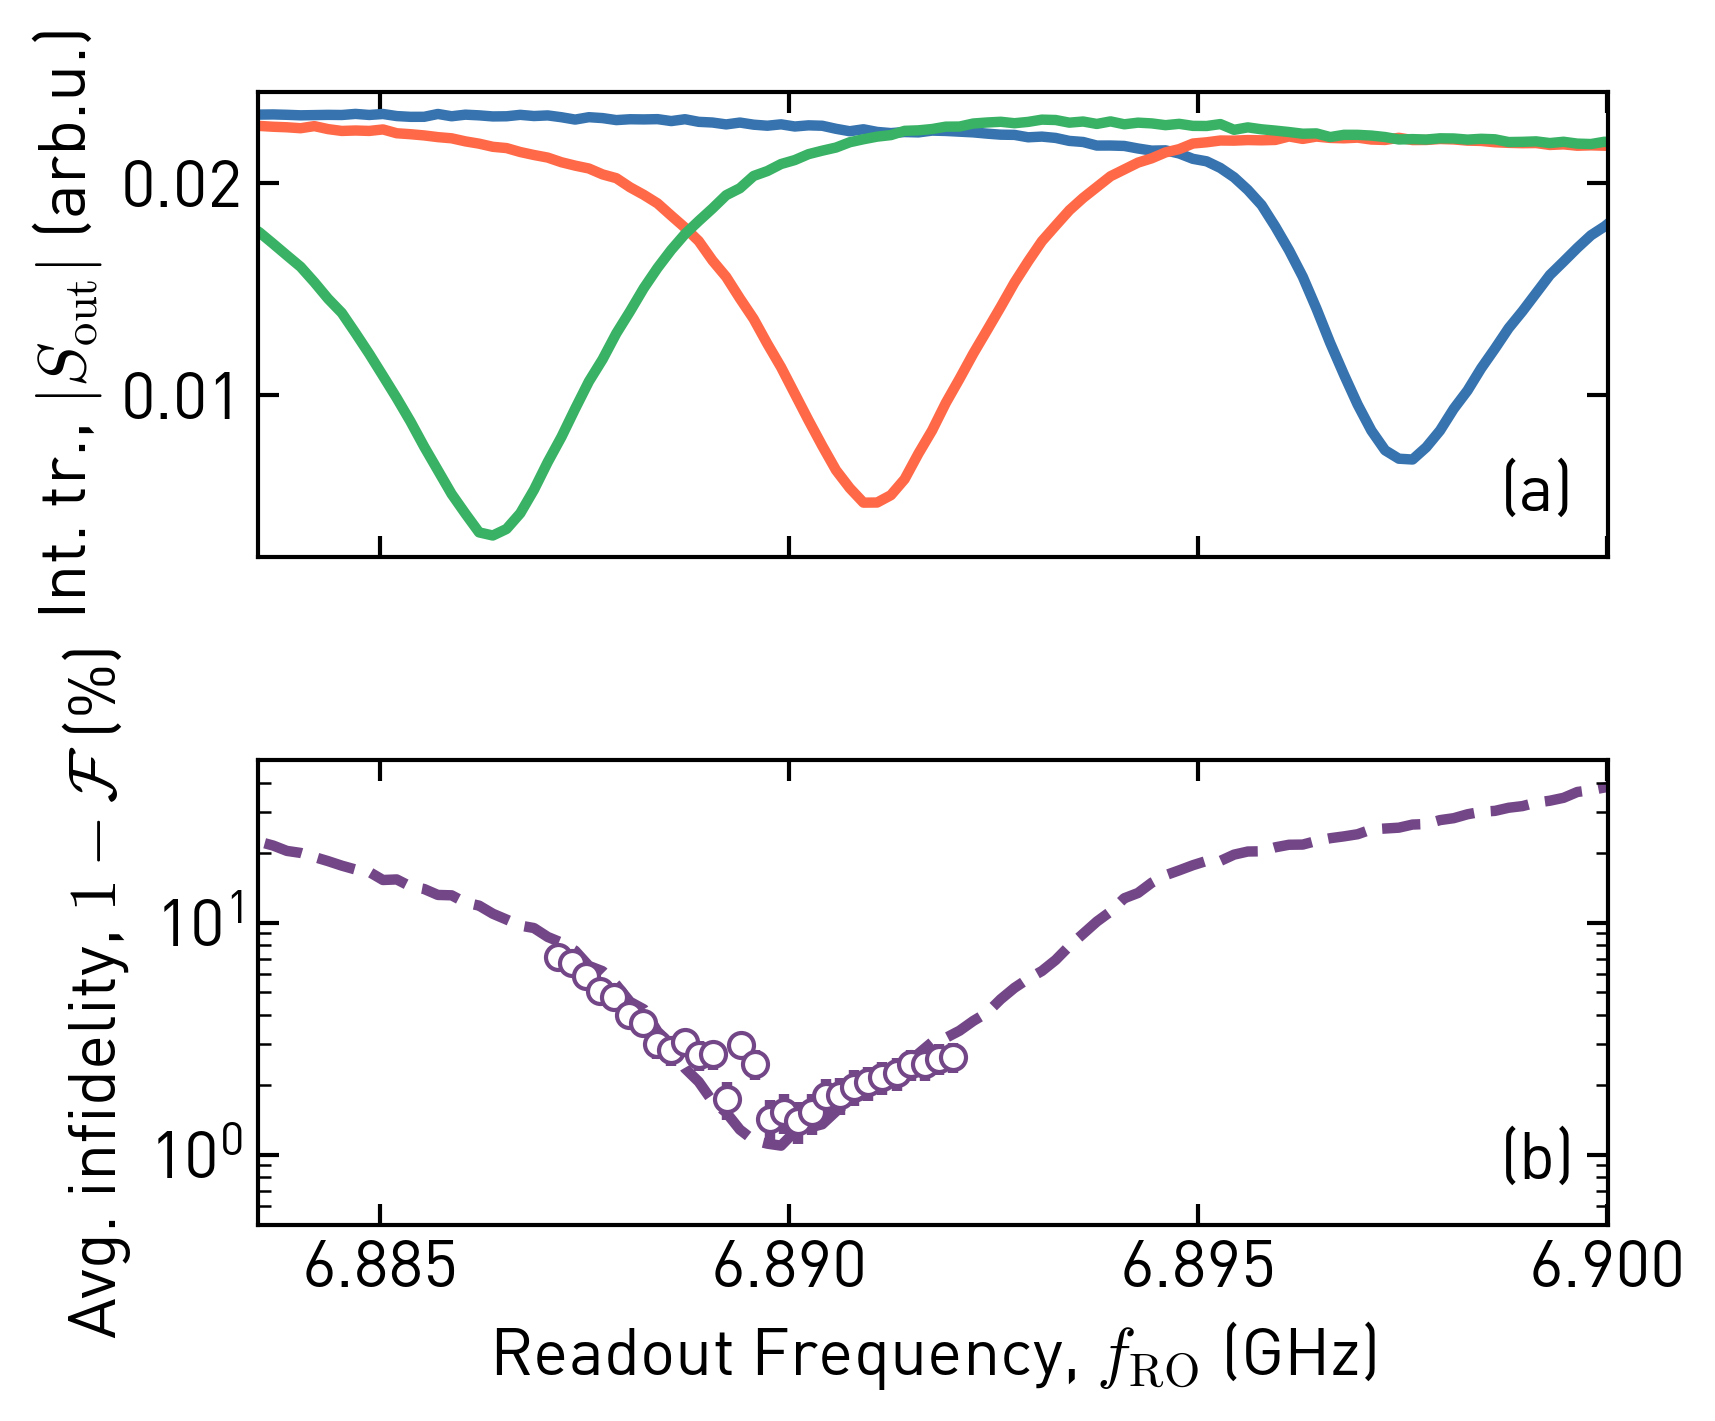

In [154]:
fig, ax = plt.subplots(2, figsize=(6,fig_size[1]), sharex=True)
# plot traces
ax[0].plot(freqs_spec*1e-9, np.abs(trace['g']), label='g', color=colors[0])
ax[0].plot(freqs_spec*1e-9, np.abs(trace['e']), label='e', color=colors[1])
ax[0].plot(freqs_spec*1e-9, np.abs(trace['f']), label='f', color=colors[2])
ax[0].set_ylabel(r'Int. tr., $|S_{\mathrm{out}}|$ (arb.u.)')

ax[1].plot(freqs_spec*1e-9, (1 - avg_fidelity_spec)*100 , color=c, linestyle='--', label="Model", zorder=-1)
# ax[1].scatter(ssb_ro_freqs[plot_start:plot_end], (1 - ssb_avg_fid_masked[plot_start:plot_end])*100,
#             marker='o', label="Preselection", zorder=0, color='k', edgecolor='k', facecolor='none')
ax[1].errorbar(ssb_ro_freqs[plot_start:plot_end], 
              (1 - ssb_avg_fid_masked[plot_start:plot_end] - infidelity_from_decay)*100, errorbars_fid[plot_start:plot_end],
            marker='o', label="T$_1$ corrected", zorder=0, color='w', alpha=1, fmt=' ', markeredgecolor=c, ecolor=c)
ax[1].set_xlabel("Readout Frequency, $f_{\mathrm{RO}}$ (GHz)")
ax[1].set_ylabel("Avg. infidelity, $1 - \mathcal{F}$ (%)")
# ax.set_ylim([0.0001,0.1])
# ax[1].axvline(ssb_ro_freqs[np.argmax(avg_fidelity)], linestyle='--', color='C0')#,label='Expected best readout frequency')
# ax.axvline(ssb_ro_freqs[np.argmax(ssb_avg_fid_masked)], linestyle='--', label='Best measured readout frequency', color='C2')
ax[1].set_xlim(6.8835,6.9)
ax[1].set_ylim(0.5, 50)
ax[1].set_yscale('log')

for a, l in zip(ax.flatten(), ['(a)', '(b)']):
    a.text(0.92,0.1, l, transform=a.transAxes)
fig.tight_layout()
# ax[1].legend()

In [116]:
fig.savefig(figsave_base + "ch3_readout_frequency_opt_{:%Y%m%d_%H%M%S}.png".format(datetime.datetime.now()),
            transparent=False)

## Plot IQ plane

In [33]:
ssb_ro_freqs[idx_max_fid]

6.8901034482758625

In [18]:
idx_max_fid = np.argmax(ssb_avg_fid_masked)
ts = tps[3*idx_max_fid: 3*(idx_max_fid + 1)]
agmm = ra.Singleshot_Readout_Analysis_Qutrit(auto=False,
                                                   t_start = list(ts),
                                                   levels=levels,
                                                   options_dict=options)
agmm.extract_data()

for i in range(len(levels)):
    [agmm.raw_data_dict[i]["measured_data"].update({k: v*rescale}) for k, v in agmm.raw_data_dict[i]["measured_data"].items() ]
agmm.process_data()

shots_to_plot = []
shot_labels = []
n_shots_per_state = 10000
thresholded = False
for state in np.unique(agmm.proc_data_dict['data_masked']['prep_states']):
    shots_to_plot_state_i = []
    shots, labels = iter(agmm.proc_data_dict['data_masked']['X']), iter(agmm.proc_data_dict['data_masked']['prep_states'])
    while len(shots_to_plot_state_i) < n_shots_per_state:
        try:
            s, l = next(shots), next(labels)
            if l == state:
                shots_to_plot_state_i.append(s)
                shot_labels.append(l)
        except Exception as e:
            raise e
            print(f"Only {len(shots_to_plot_state_i)} shots found for state {state}")
            break
    shots_to_plot.extend(shots_to_plot_state_i)
    
shots_to_plot = np.array(shots_to_plot)
shot_labels = np.array(shot_labels)

if not thresholded:
    means = agmm.proc_data_dict['analysis_params']['classifier_params']['means_']
    covariances = [agmm.proc_data_dict['analysis_params']['classifier_params']['covariances_'] for _ in range(3)]
else:
    thresholds = agmm.proc_data_dict['analysis_params']['classifier_params']['thresholds']

colors = ['#3673AF','#FF6947', "#39B265"]
cmap = matplotlib.colors.ListedColormap(colors)

In [19]:
agmm.clf_.weights_ = [1/3, 1/3, 1/3]

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
kwargs = dict(fig=fig, scale="linear", show=False, frameon=True, colors=colors, 
              alpha=0.7)
# fig = agmm.plot_scatter_and_marginal_hist(shots_to_plot,shot_labels, **kwargs)
axes = fig.get_axes()
axes[0].set_aspect('equal')

# axes[1].spines["top"].set_visible(False)
# axes[1].spines["right"].set_visible(False)
# axes[1].yaxis.set_tick_params(right=False)
# axes[1].xaxis.set_tick_params(right=False, top=False)

# axes[2].spines["top"].set_visible(False)
# axes[2].spines["right"].set_visible(False)
# axes[2].yaxis.set_tick_params(right=False, top=False)
# axes[2].xaxis.set_tick_params(right=False, top=False)

axes[0].set_xlabel(r'Integrated quadrature, $\tilde{I}$ (arb.u.)')
axes[0].set_ylabel(r'Integrated quadrature, $\tilde{Q}$ (arb.u.)')

plt.subplots_adjust(wspace=0.00, hspace=0)

# add kde
# from scipy import stats

# kde_x = stats.gaussian_kde(shots_to_plot[:, 0], )
# xx = np.linspace(-0.9, 0.2, 1000)
# axes[2].plot(xx, kde_x(xx)*500)



# add background
agmm.plot_clf_boundaries(shots_to_plot, agmm.clf_, ax=axes[0], cmap=cmap, h=0.0001 )
for m, cov in zip(means, covariances):
    agmm.plot_std(m, cov, n_std=1, ax=axes[0], edgecolor='w', linestyle='--', linewidth=2)
    axes[0].scatter([m[0]], [m[1]], color='w')
#     ssqtro.plot_std(m, cov, n_std=2, ax=axes[0], edgecolor='w', linestyle='--', linewidth=1.5)
#     ssqtro.plot_std(m, cov, n_std=3, ax=axes[0], edgecolor='w', linestyle='--', linewidth=1.5)

# add thresholds
if thresholded:
    axes[0].axvline(thresholds[0], linestyle='--', color='k')
    axes[0].axhline(thresholds[1], linestyle='--', color='k')
#     axes[0].text(-0.85, -0.65,"0b00", color=colors[0], weight='bold')
#     axes[0].text(0.05, -0.65,"0b01", color=colors[1], weight='bold')
#     axes[0].text(-0.85, 0.35,"0b10", color=colors[2], weight='bold')
#     axes[0].text(0.05, 0.35, "0b11",color=colors[2], weight='bold')


## Plot iq plane and freqs

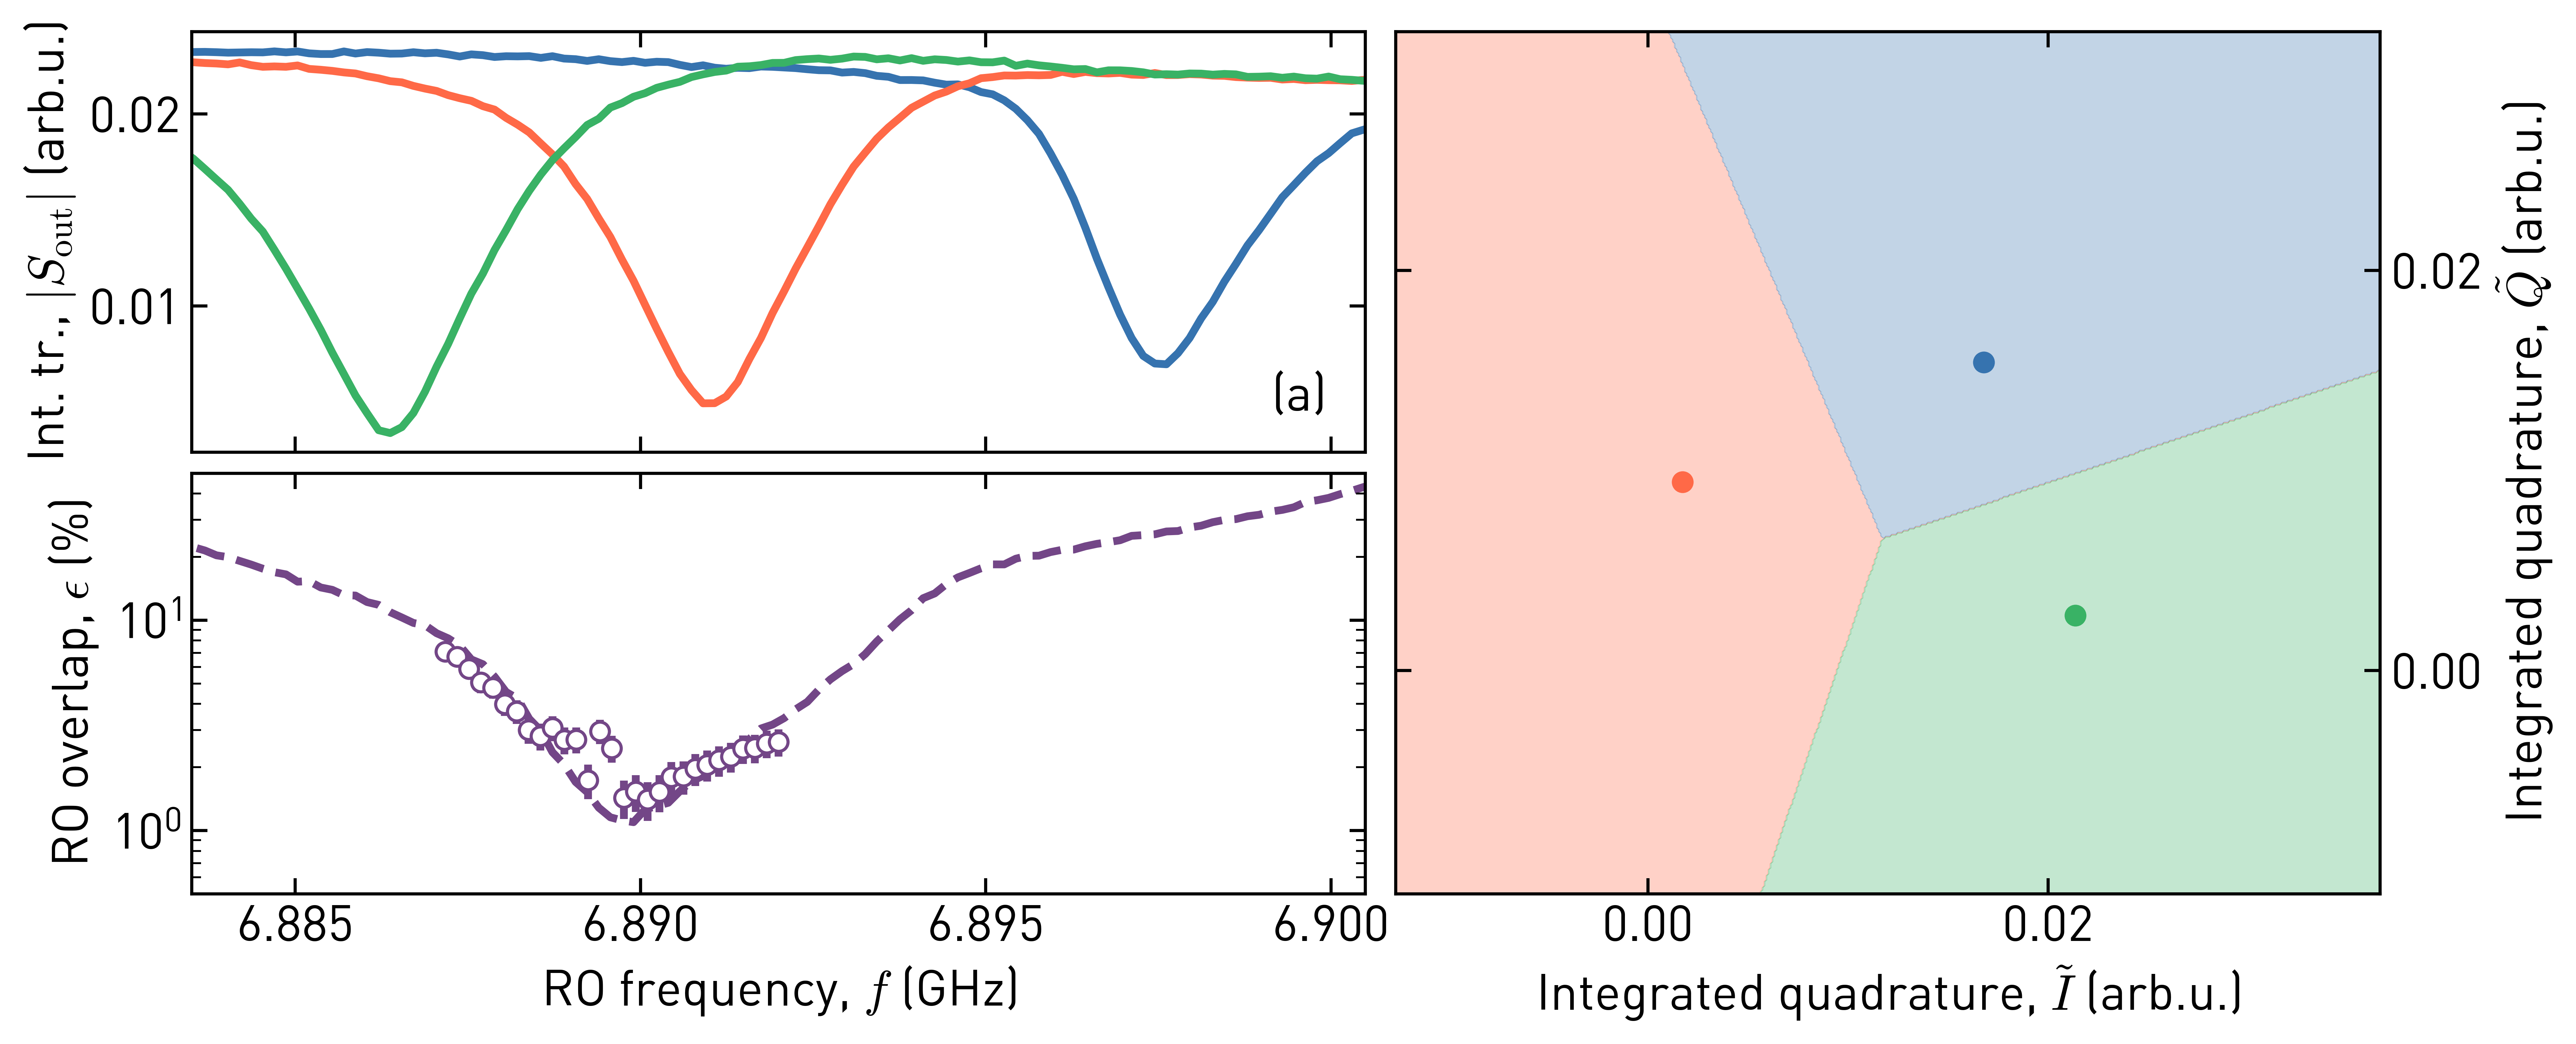

In [40]:
# freq stuff
fig, ax = plt.subplots(2,2, figsize=(12.2,5),sharex=True, gridspec_kw={'width_ratios': [0.8,1]})
# plot traces
ax[0,0].plot(freqs_spec*1e-9, np.abs(trace['g']), label='g', color=colors[0])
ax[0,0].plot(freqs_spec*1e-9, np.abs(trace['e']), label='e', color=colors[1])
ax[0,0].plot(freqs_spec*1e-9, np.abs(trace['f']), label='f', color=colors[2])
ax[0,0].set_ylabel(r'Int. tr., $|S_{\mathrm{out}}|$ (arb.u.)')

c = '#734687'
ax[1,0].plot(freqs_spec*1e-9, (1 - avg_fidelity_spec)*100 , color=c, linestyle='--', label="Model", zorder=-1)
# ax[1].scatter(ssb_ro_freqs[plot_start:plot_end], (1 - ssb_avg_fid_masked[plot_start:plot_end])*100,
#             marker='o', label="Preselection", zorder=0, color='k', edgecolor='k', facecolor='none')
ax[1,0].errorbar(ssb_ro_freqs[plot_start:plot_end], 
              (1 - ssb_avg_fid_masked[plot_start:plot_end] - infidelity_from_decay)*100, errorbars_fid[plot_start:plot_end],
            marker='o', label="T$_1$ corrected", zorder=0, color='w', alpha=1, fmt=' ', markeredgecolor=c, ecolor=c)
ax[1,0].set_xlabel("RO frequency, $f$ (GHz)")
ax[1,0].set_ylabel(r"RO overlap, $\epsilon$ (%)")
# ax.set_ylim([0.0001,0.1])
# ax[1].axvline(ssb_ro_freqs[np.argmax(avg_fidelity)], linestyle='--', color='C0')#,label='Expected best readout frequency')
# ax.axvline(ssb_ro_freqs[np.argmax(ssb_avg_fid_masked)], linestyle='--', label='Best measured readout frequency', color='C2')
ax[1,0].set_xlim(6.8835,6.9005)
ax[1,0].xaxis.set_ticks([6.885, 6.890, 6.895, 6.900])

ax[1,0].set_ylim(0.5, 50)
ax[1,0].set_yscale('log')

for a, l in zip(ax.flatten(), ['(a)', '(b)']):
    a.text(0.92,0.1, l, transform=a.transAxes)
fig.tight_layout()
# ax[1].legend()

gs = ax[0, 1].get_gridspec()
# remove the underlying axes
for a in ax[:, 1]:
    a.remove()
axbig = fig.add_subplot(gs[:, -1])

#### IQ plane stuff
kwargs = dict(fig=fig, scale="linear", show=False, frameon=True, colors=colors, 
              alpha=0.7)
# fig = agmm.plot_scatter_and_marginal_hist(shots_to_plot,shot_labels, **kwargs)
axes = fig.get_axes()
axes[2].set_aspect('equal')


axes[2].set_xlabel(r'Integrated quadrature, $\tilde{I}$ (arb.u.)')
axes[2].set_ylabel(r'Integrated quadrature, $\tilde{Q}$ (arb.u.)')
axes[2].yaxis.set_label_position("right")
axes[2].set_yticks([0, 0.02])
axes[2].set_xticks([0, 0.02])

axes[2].yaxis.tick_right()
axes[2].yaxis.set_ticks_position('both')

plt.subplots_adjust(wspace=-0.160, hspace=0.05)


# add background
agmm.plot_clf_boundaries(shots_to_plot, agmm.clf_, ax=axes[2], cmap=cmap, h=0.0001 )
for m, cov, c in zip(means, covariances,colors):
#     agmm.plot_std(m, cov, n_std=1, ax=axes[2], edgecolor=, linestyle='--', linewidth=2)
    axes[2].scatter([m[0]], [m[1]], color=c)

In [38]:
fig.savefig(figsave_base + "\\ch3_readout_frequency_opt__with_iq_{:%Y%m%d_%H%M%S}.png".format(datetime.datetime.now()),
            transparent=False)

# Scratchpad

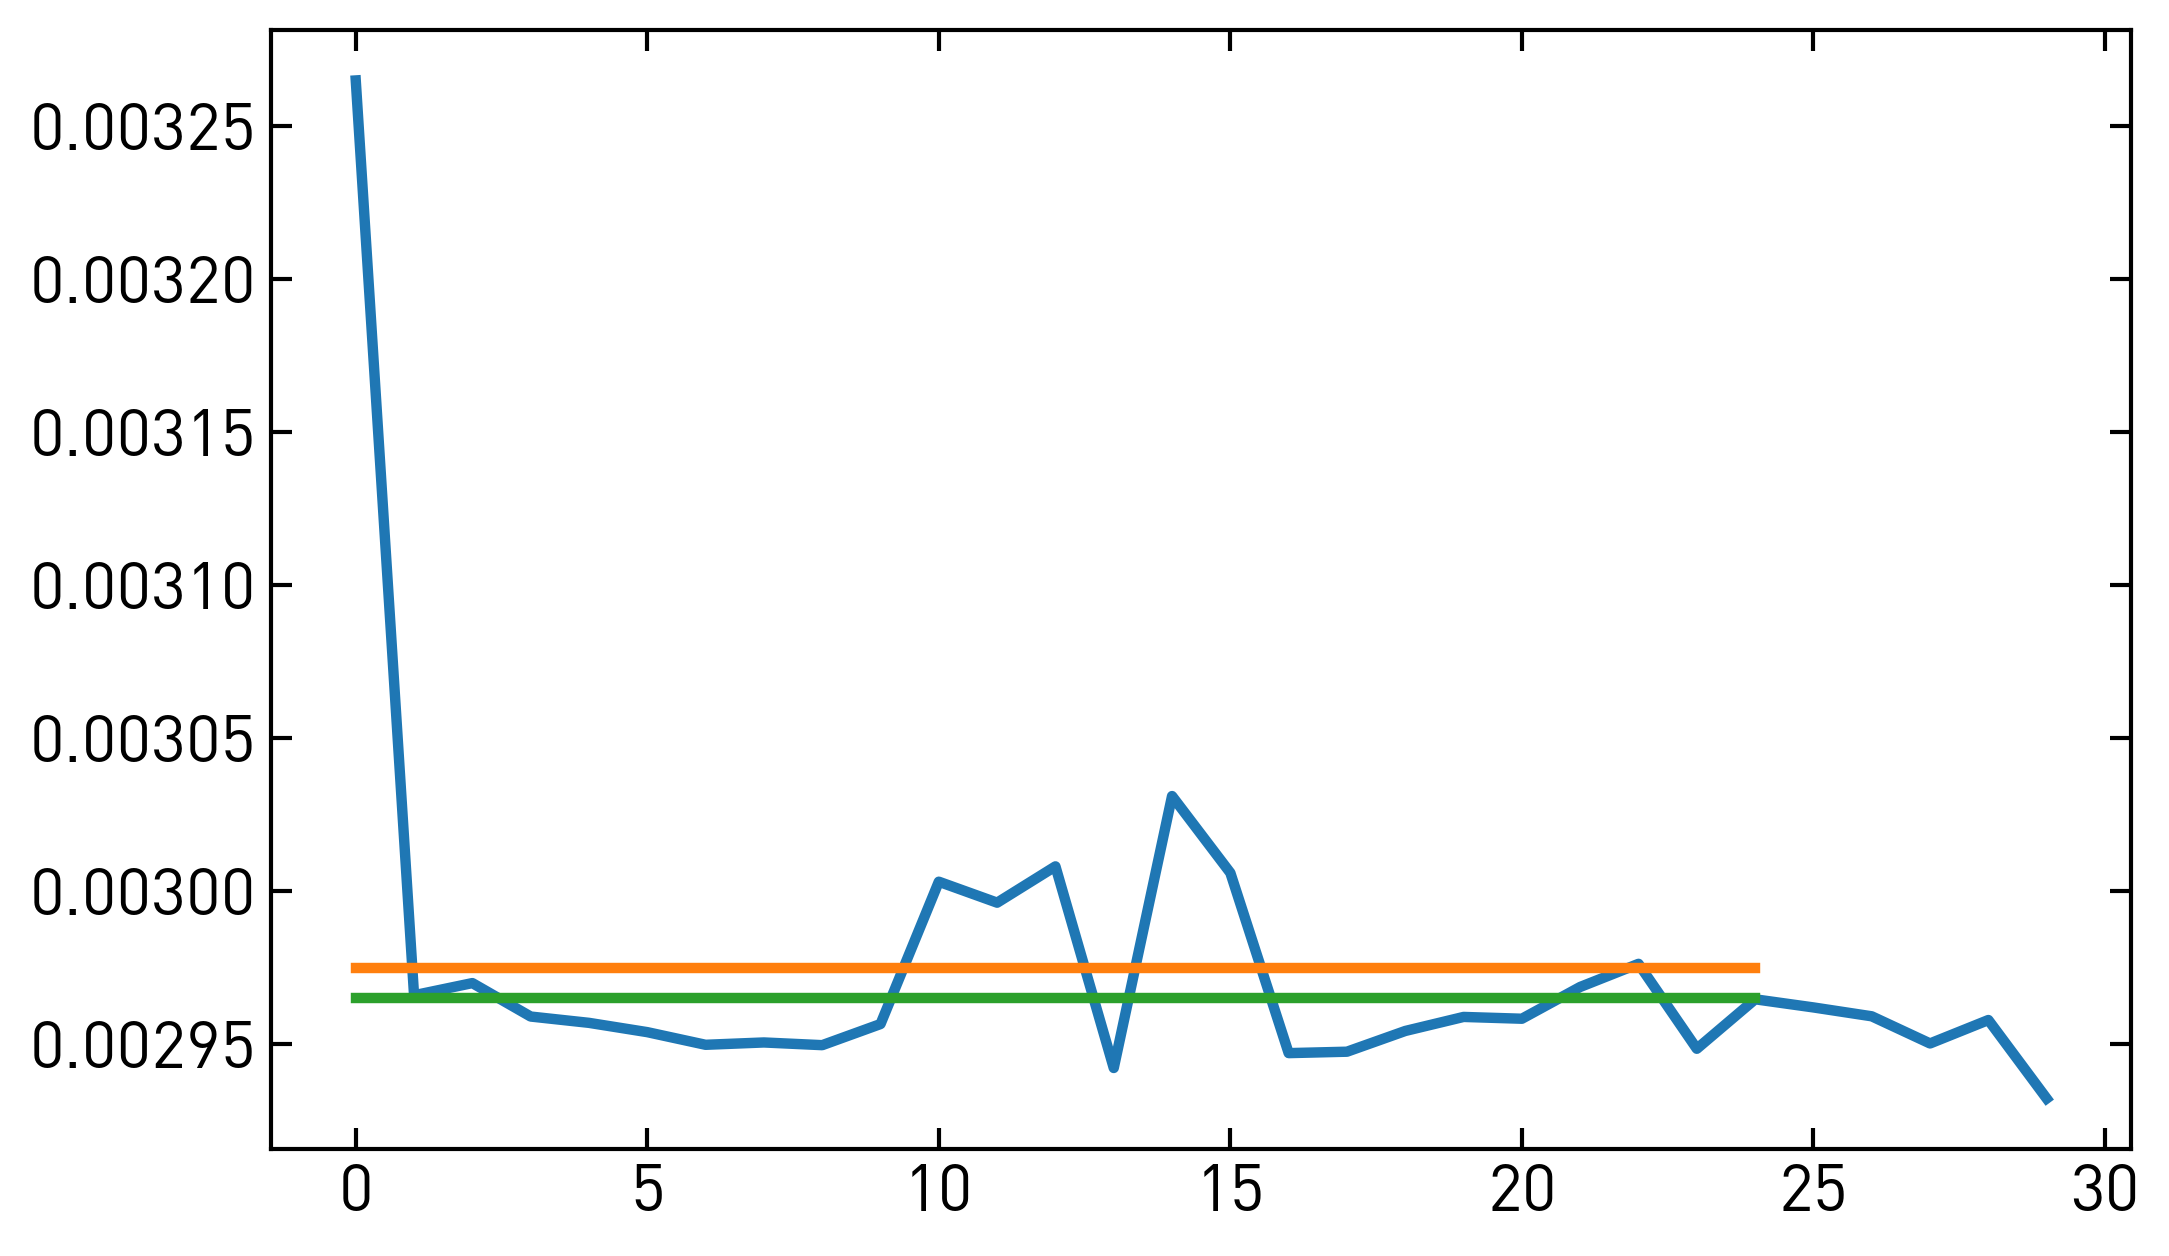

In [108]:
for i in range(3):
    plt.plot(np.sqrt([np.mean(c[i][np.eye(2, dtype=bool)]) for c in cov]))
plt.plot(stds, color='k')

## Measurement infidelity each state independently

In [106]:
# Compute expected infidelity
fidelity_levels = np.squeeze(np.array([list(evaluate_fidelity(m, s)[1].values()) for m, s in zip(means_cpx, stds)]))


Text(0, 0.5, 'Average Infidelity (%)')

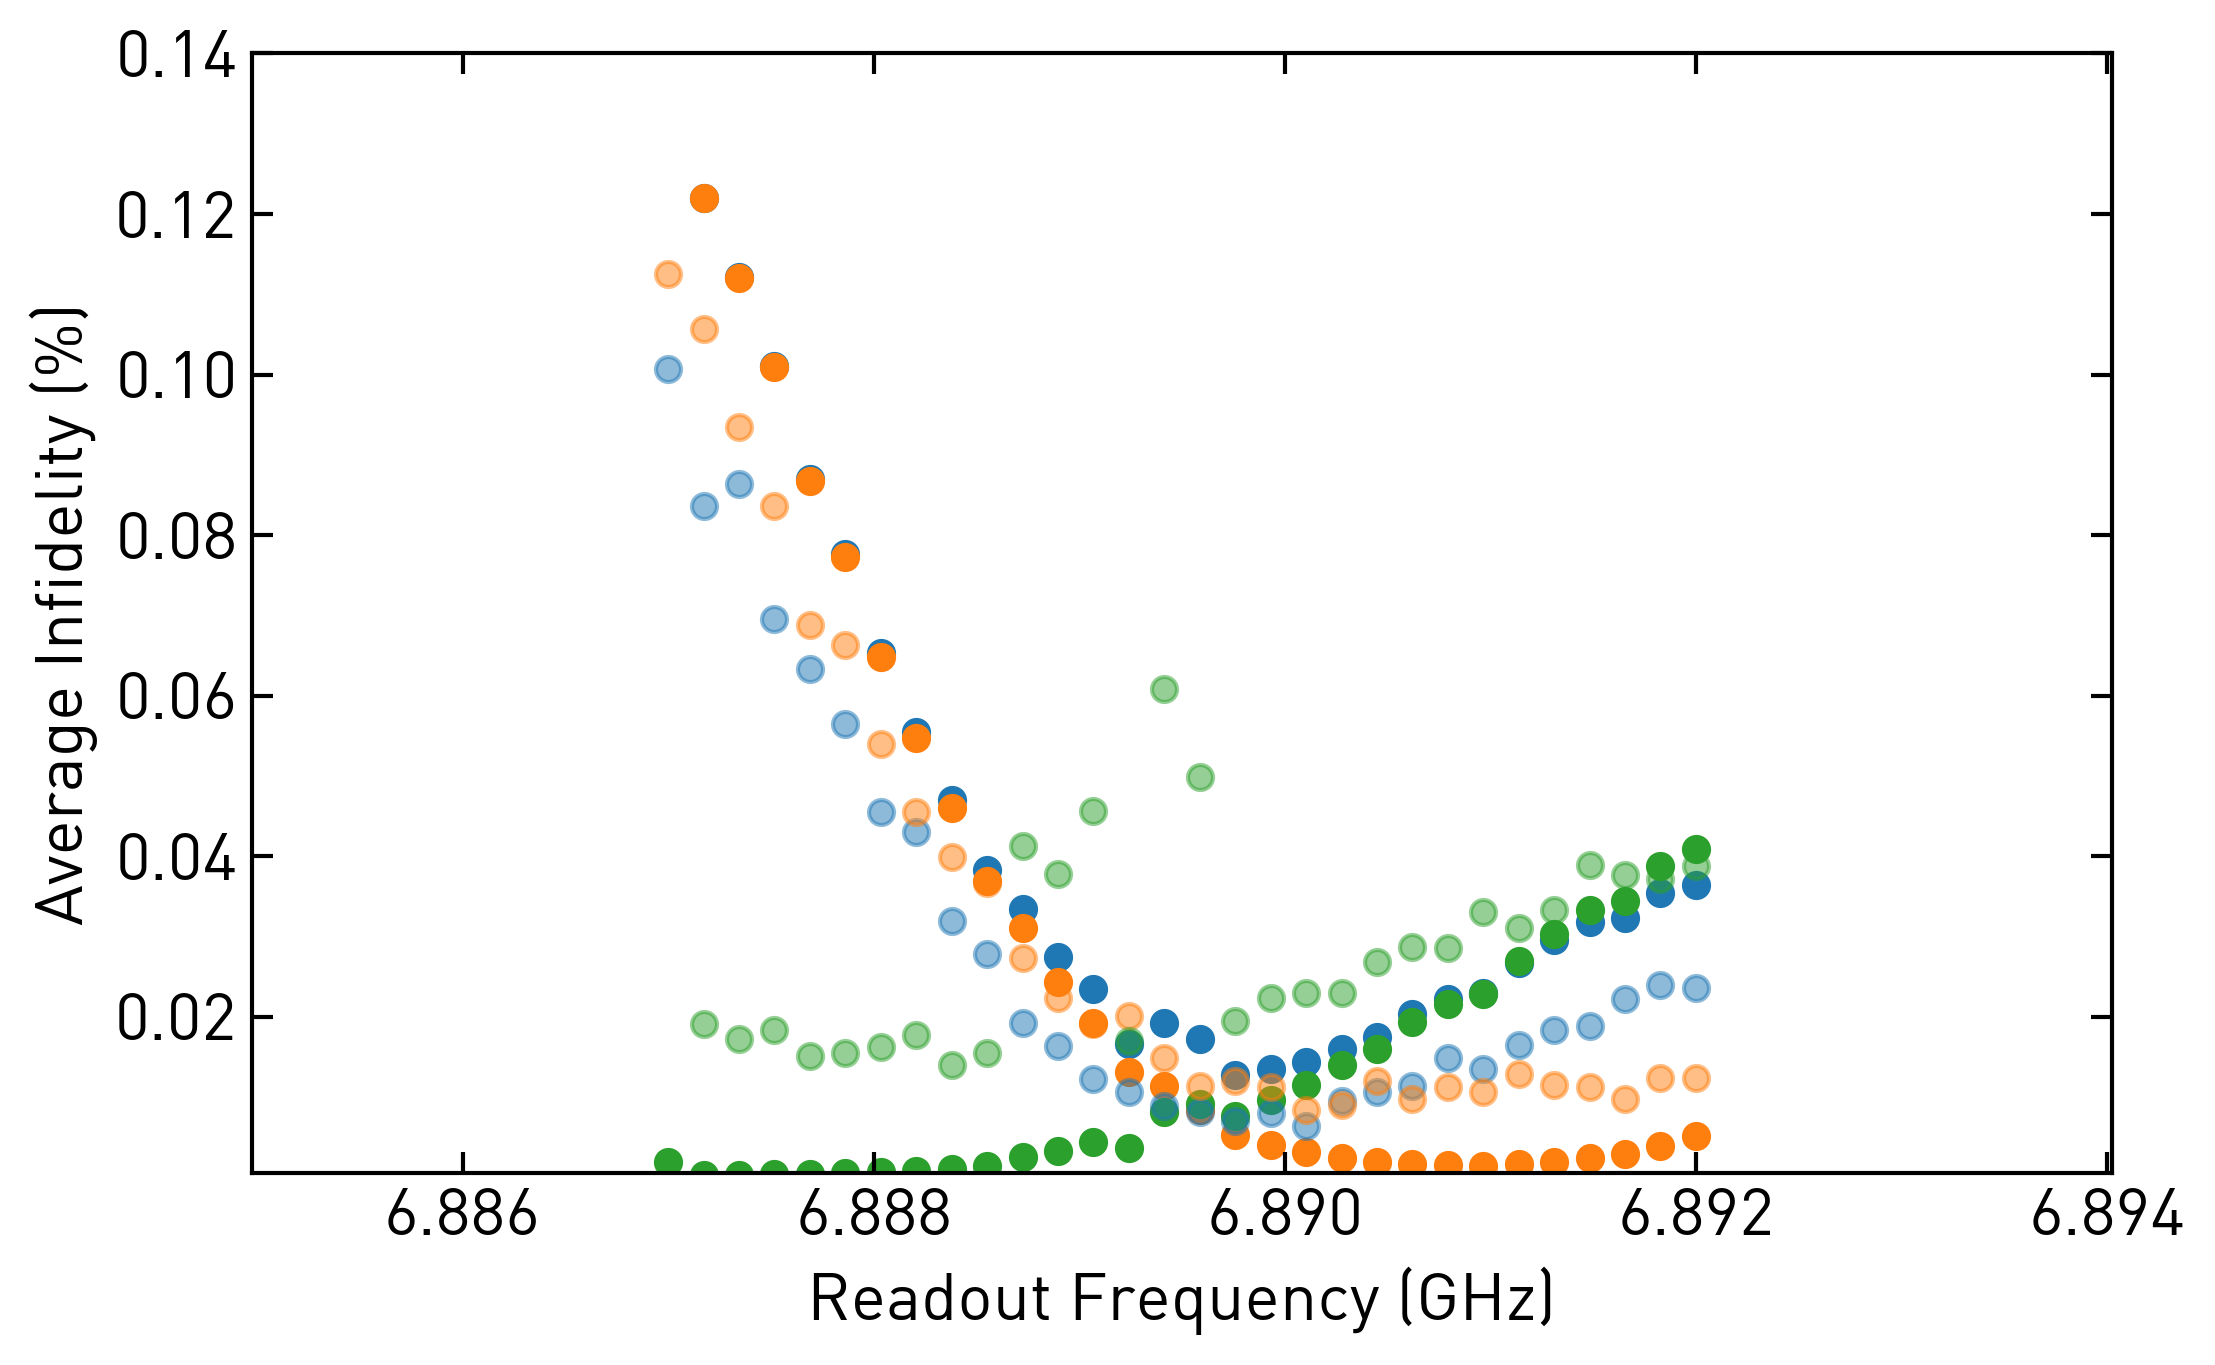

In [161]:
fig, ax = plt.subplots()
for i, l in enumerate(levels):
    ax.scatter(ssb_ro_freqs, 1-fidelity_levels[:, i])
    
# for i, l in enumerate(levels):
#     ax.scatter(ssb_ro_freqs, 1-state_assignment_prob_mtx_masked[:, i, i], color=f'C{i}', alpha = 0.5)

# # with presel
for i, l in enumerate(levels):
    if l== 'g':
        ax.scatter(ssb_ro_freqs, 1-state_assignment_prob_mtx_masked[:, i, i] , color=f'C{i}', alpha = 0.5)
    if l == 'e':
        ax.scatter(ssb_ro_freqs, 1-state_assignment_prob_mtx_masked[:, i, i] - err_t1_ge, color=f'C{i}', alpha = 0.5)
    if l == 'f':
        ax.scatter(ssb_ro_freqs, 1-state_assignment_prob_mtx_masked[:, i, i] - err_t1_ef - err_t1_ge/2, color=f'C{i}', alpha = 0.5)
        
# no presel
# for i, l in enumerate(levels):
#     if l== 'g':
#         ax.scatter(ssb_ro_freqs, 1-state_assignment_prob_mtx[:, i, i] , color=f'C{i}', alpha = 0.5)
#     if l == 'e':
#         ax.scatter(ssb_ro_freqs, 1-state_assignment_prob_mtx[:, i, i] - err_t1_ge, color=f'C{i}', alpha = 0.5)
#     if l == 'f':
#         ax.scatter(ssb_ro_freqs, 1-state_assignment_prob_mtx[:, i, i] - err_t1_ef, color=f'C{i}', alpha = 0.5)
ax.set_yscale('linear')
ax.set_ylim([0.0005, 0.14])
ax.set_xlabel("Readout Frequency (GHz)")
ax.set_ylabel("Average Infidelity (%)")
# ax.axvline(ssb_ro_freqs[np.argmax(avg_fidelity)]*1e-9, linestyle='--', color='C0')#,label='Expected best readout frequency')
# ax.axvline(ssb_ro_freqs[np.argmax(ssb_avg_fid_masked)]*1e-9, linestyle='--', label='Best measured readout frequency', color='C2')


# T1 decay


In [20]:
t1_ge = 27.7 #25.88
t1_ef = t1_ge/np.sqrt(2)
int_length = 0.2 # because time required for integral of signal to distinguish g and e = 1/2. #0.400 / 2 # assuming decays are falsy classified only if decay in first half of measurement
t = np.linspace(0, 10, 1000)
err_t1_ge = 1- np.exp(-1/t1_ge*int_length)
err_t1_ge

0.007194213462988985

responsibility of T1 decay

In [21]:
t1_ef = t1_ge/np.sqrt(2)
err_t1_ef = 1 - np.exp(-1/t1_ef*int_length)
err_t1_ef 

0.010158973705407304

In [22]:
infidelity_from_decay = 1/3*err_t1_ge + 1/3*err_t1_ef
infidelity_from_decay # average infidelity explained by decay

0.005784395722798763

In [45]:
import pandas as pd
from pycqed.analysis_v2 import spectroscopy_analysis as sa
# thermal population estimates
preselection = True
df = pd.DataFrame()
if preselection:
    state_prob_mtx = agmm.proc_data_dict['analysis_params']['state_prob_mtx']
    state_prob_mtx_masked = agmm.proc_data_dict['analysis_params']['state_prob_mtx_masked']
    therm_pop_err = state_prob_mtx - state_prob_mtx_masked
    diag_mask = ~np.diag(np.ones(len(state_prob_mtx), dtype=bool))
    therm_pop_err = np.sum(therm_pop_err * diag_mask, axis=1)
    df['Thermal population'] = np.concatenate([therm_pop_err, [np.mean(therm_pop_err)]])

# decay errors
decay_err = np.zeros(len(states))
for i, state in enumerate(states):
    if state == 'g':
        decay_err[i] = 0
    elif state == 'e':
        decay_err[i] = 1 - np.exp(-1 / t1_ge * (int_length))
    elif state == 'f':
        decay_err[i] = 1 - np.exp(-1 / t1_ef * (int_length))
df['Decay'] = np.concatenate([decay_err, [np.mean(decay_err)]])

# Readout overlap
if len(states) == 3:
    sigma = np.sqrt(np.mean(agmm.proc_data_dict["analysis_params"]["classifier_params"]['covariances_'][np.eye(2, dtype=bool)]))
    means_cpx = {s: [complex(*agmm.proc_data_dict["analysis_params"]["classifier_params"]['means_'][i])]
                for i, s in enumerate(states)}
    err_tot_overlap = (1 - sa.ResonatorSpectroscopy_v2.three_gaussians_overlap(means_cpx, sigma_exp)[0][0])
    df['Readout Overlap'] = [np.nan]*len(states) +  [err_tot_overlap]
df.index = [s for s in states] + ["Average"]

# Other
avg_fid = np.average(state_prob_mtx[np.eye(len(states), dtype=bool)])
other = 1 - np.concatenate([state_prob_mtx[np.eye(len(states), dtype=bool)], [avg_fid]]) - df.transpose().sum()
df['Other']  = other

In [46]:
df

,Thermal population,Decay,Readout Overlap,Other
g,0.009627,0.000000,NaN,0.001213
e,0.011601,0.015804,NaN,0.001116
f,0.012488,0.026453,NaN,-0.000122
Average,0.011239,0.014086,0.000715,0.000021


In [40]:
_, counts = np.unique(agmm.proc_data_dict['data_masked']['prep_states'], return_counts=True)
weights = counts/np.sum(counts)

In [265]:
import pandas as pd
import numpy as np
import subprocess

df = pd.DataFrame({'d': [1., 1., 1., 2., 2., 2.],
                   'c': np.tile(['a', 'b', 'c'], 2),
                   '': np.arange(1., 7.)})
filename = 'out.tex'
pdffile = 'out.pdf'
# outname = 'out.png'

template = r'''\documentclass[preview]{{standalone}}
\usepackage{{booktabs}}
\begin{{document}}
{}
\end{{document}}
'''

with open(filename, 'w') as f:
    f.write(template.format(df.to_latex()))

subprocess.call(['pdflatex', filename])

1